In [5]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [6]:
Year = "2019"
Month = "12"
Day = "15"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)
folder_processed = r"/data/new_trap_processed/harmonics_processed/"+ Year + Month + Day + "/Bead"+str(BeadNumber)


In [7]:
# calibration of the voltage - position conversion

def voltage_to_y_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

def extract_freq_and_stroke(cant_pos_y):
    stroke = voltage_to_y_position(np.std(cant_pos_y)*np.sqrt(2))
    return 2*stroke

In [8]:
def get_harmonics_with_sideband(input_psd,shake_freq,no_harmonics,res_factor=10,sum_range=0,sideband_spacing=-7,plot=False):
    harmonics = []
    sideband = []
    FreqTF = np.arange(shake_freq,(shake_freq*no_harmonics+shake_freq),shake_freq)
    for i in range(no_harmonics):
        harmonics_sum = input_psd[shake_freq*res_factor*(i+1)]+ input_psd[(shake_freq+sum_range)*res_factor*(i+1)]+input_psd[(shake_freq-sum_range)*res_factor*(i+1)]
        harmonics.append(harmonics_sum)
        #side_up = input_psd[(shake_freq+sideband_spacing)*res_factor*(i+1)]
        #side_down = input_psd[(shake_freq-sideband_spacing)*res_factor*(i+1)]
        #sideband.append(np.divide(np.sum(side_up,side_down),2))
        sideband.append(input_psd[(shake_freq+sideband_spacing)*res_factor*(i+1)])
    if(plot==True):
        plt.plot(FreqTF,harmonics, marker ="o", linestyle ="")
        plt.yscale("log")
        #plt.show()
    #print(harmonics_sum)
    return FreqTF,harmonics,sideband     

In [126]:
def data_to_amp_and_phase(data,fsamp,res):
    data_det=signal.detrend(data)
    res = res
    fsamp = fsamp # stays hard coded for now
    freqs=np.linspace(0,int(fsamp/2),int(res/2)+1)    # change
    xFFT=np.fft.rfft(data_det[0])
    yFFT=np.fft.rfft(data_det[1])
    zFFT=np.fft.rfft(data_det[2])
    norm = np.sqrt(2 / (res* fsamp))
    xpsd = norm**2 * (xFFT * xFFT.conj()).real
    ypsd = norm**2 * (yFFT * yFFT.conj()).real
    zpsd = norm**2 * (zFFT * zFFT.conj()).real
    xphase=np.angle(xFFT)
    yphase=np.angle(yFFT)
    zphase=np.angle(zFFT)
    return xpsd,ypsd,zpsd,xphase,yphase,zphase

In [127]:
def spin_data_to_amp_and_phase(data,fsamp,res):
    data_det=signal.detrend(data)
    res = res
    fsamp = fsamp # stays hard coded for now
    freqs=np.linspace(0,int(fsamp/2),int(res/2)+1)    # change
    print(freqs)
    xFFT=np.fft.rfft(data_det)
    norm = np.sqrt(2 / (res* fsamp))
    xpsd = norm**2 * (xFFT * xFFT.conj()).real
    xphase=np.angle(xFFT)
    return freqs,xpsd,xphase

In [107]:
def harmonics_processor_basic_with_spin(folder,filename_input,filename_output,max_file=5,shake_freq=13,no_harmonics=10,fsamp=5000,res=50000,res_factor=10,save_file=True):
    path="/harmonics/"
    #try:
    #    os.mkdir(path)
    #except OSError:
    #    print ("Creation of the directory %s failed" % path)
    #else:
    #    print ("Successfully created the directory %s " % path)
        
    # load files and initialize processor
    files = load_dir_sorted(folder, file_prefix =filename_input, max_file=max_file)

    harmonic_list_x, sideband_list_x, phase_list_x, sidephase_list_x =([] for i in range(4))
    harmonic_list_y, sideband_list_y, phase_list_y, sidephase_list_y =([] for i in range(4))
    harmonic_list_z, sideband_list_z, phase_list_z, sidephase_list_z =([] for i in range(4))

    xmean_list,ymean_list,zmean_list = ([] for i in range(3))
    cant_xpos_list,cant_ypos_list,cant_zpos_list=([] for i in range(3))      
    freq_list,time_stamp_list = ([] for i in range(2))
    stroke_list = []
    spin_list = []
    
    for i in tqdm(np.arange(0,len(files),1)):
        #print(files[i].fname)
        data = files[i].xyz2
        spin_data = files[i].spin_data
        freq,spin_amp, spin_phase = spin_data_to_amp_and_phase(spin_data,10*fsamp,10*res)
        spin_list.append(spin_amp)
        
        
        xmean_list.append(np.mean(files[i].x2))
        ymean_list.append(np.mean(files[i].y2))
        zmean_list.append(np.mean(files[i].z2))
        
        cant_xpos_list.append(np.mean(files[i].cant_pos[0]))
        cant_ypos_list.append(np.mean(files[i].cant_pos[1]))
        cant_zpos_list.append(np.mean(files[i].cant_pos[2]))
        
        stroke_list.append(np.mean(extract_freq_and_stroke(files[i].cant_pos[1])))
        
        time_stamp_list.append(files[i].time[0])
        
        FFT_and_phases = data_to_amp_and_phase(data,fsamp,res)
        freqs,harmonics_x,sidebands_x = get_harmonics_with_sideband(FFT_and_phases[0],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_y,sidebands_y = get_harmonics_with_sideband(FFT_and_phases[1],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_z,sidebands_z = get_harmonics_with_sideband(FFT_and_phases[2],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        freq_list.append(freqs)
        
        harmonic_list_x.append(np.sqrt(harmonics_x))     
        harmonic_list_y.append(np.sqrt(harmonics_y))     
        harmonic_list_z.append(np.sqrt(harmonics_z))     
        
        sideband_list_x.append(np.sqrt(sidebands_x))     
        sideband_list_y.append(np.sqrt(sidebands_y))     
        sideband_list_z.append(np.sqrt(sidebands_z))     

        
        _,phases_x,sidephases_x = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_y,sidephases_y = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_z,sidephases_z = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        phase_list_x.append(phases_x)
        phase_list_y.append(phases_y)
        phase_list_z.append(phases_z)

        sidephase_list_x.append(sidephases_x)
        sidephase_list_y.append(sidephases_y)
        sidephase_list_z.append(sidephases_z)


    # make the dataframe and fill it
    df = pd.DataFrame()
    df["start_time"]=time_stamp_list
    df["stroke"]=stroke_list
    df["x_mean"]=xmean_list
    df["y_mean"]=ymean_list
    df["z_mean"]=zmean_list
    df["attractor_position_x"]=cant_xpos_list
    df["attractor_position_y"]=cant_ypos_list
    df["attractor_position_z"]=cant_zpos_list
    # frequencies
    df["frequency"] = freq_list
    df["amplitude_x"] = harmonic_list_x
    df["amplitude_y"] = harmonic_list_y
    df["amplitude_z"] = harmonic_list_z
    
    df["phase_x"] = phase_list_x
    df["phase_y"] = phase_list_y
    df["phase_z"] = phase_list_z
    df["sideband_amplitude_x"] = sideband_list_x
    df["sideband_amplitude_y"] = sideband_list_y
    df["sideband_amplitude_z"] = sideband_list_z

    df["sideband_phase_x"] = sidephase_list_x
    df["sideband_phase_y"] = sidephase_list_y
    df["sideband_phase_z"] = sidephase_list_z    
    print(len(spin_amp))
    df["spin_data"] = spin_list
    
    if(save_file==True):
            if(os.path.isfile(folder+"harmonics/harmonics_basic_with_spin_%s.pkl" %filename_output)==False):
                df.to_csv(folder+"harmonics/harmonics_basic_with_spin_%s.csv" %filename_output,index=False)
                df.to_pickle(folder+"harmonics/harmonics_basic_with_spin_%s.pkl" %filename_output)
            else:print("File could not be saved, probably exists.")
    return df

In [128]:
def harmonics_processor_basic_with_spin_and_fb(folder,filename_input,filename_output,max_file=5,shake_freq=13,no_harmonics=10,fsamp=5000,res=50000,res_factor=10,save_file=True):
    path="/harmonics/"
    #try:
    #    os.mkdir(path)
    #except OSError:
    #    print ("Creation of the directory %s failed" % path)
    #else:
    #    print ("Successfully created the directory %s " % path)
        
    # load files and initialize processor
    files = load_dir_sorted(folder, file_prefix =filename_input, max_file=max_file)

    harmonic_list_x, sideband_list_x, phase_list_x, sidephase_list_x =([] for i in range(4))
    harmonic_list_y, sideband_list_y, phase_list_y, sidephase_list_y =([] for i in range(4))
    harmonic_list_z, sideband_list_z, phase_list_z, sidephase_list_z =([] for i in range(4))

    xmean_list,ymean_list,zmean_list = ([] for i in range(3))
    cant_xpos_list,cant_ypos_list,cant_zpos_list=([] for i in range(3))      
    freq_list,time_stamp_list = ([] for i in range(2))
    stroke_list = []
    spin_list = []
    x_feedback_list,y_feedback_list,z_feedback_list = ([] for i in range(3))
    
    for i in tqdm(np.arange(0,len(files),1)):
        #print(files[i].fname)
        data = files[i].xyz2
        spin_data = files[i].spin_data
    
        
        freq,spin_amp, spin_phase = spin_data_to_amp_and_phase(spin_data,10*fsamp,10*res)
        spin_list.append(spin_amp)
        
        xmean_list.append(np.mean(files[i].x2))
        ymean_list.append(np.mean(files[i].y2))
        zmean_list.append(np.mean(files[i].z2))
        
        cant_xpos_list.append(np.mean(files[i].cant_pos[0]))
        cant_ypos_list.append(np.mean(files[i].cant_pos[1]))
        cant_zpos_list.append(np.mean(files[i].cant_pos[2]))
        
        stroke_list.append(np.mean(extract_freq_and_stroke(files[i].cant_pos[1])))
        
        x_feedback_list.append(np.mean(files[i].feedback[0]))
        y_feedback_list.append(np.mean(files[i].feedback[1]))
        z_feedback_list.append(np.mean(files[i].feedback[2]))

        
        time_stamp_list.append(files[i].time[0])
        
        FFT_and_phases = data_to_amp_and_phase(data,fsamp,res)
        freqs,harmonics_x,sidebands_x = get_harmonics_with_sideband(FFT_and_phases[0],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_y,sidebands_y = get_harmonics_with_sideband(FFT_and_phases[1],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_z,sidebands_z = get_harmonics_with_sideband(FFT_and_phases[2],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        freq_list.append(freqs)
        
        harmonic_list_x.append(np.sqrt(harmonics_x))     
        harmonic_list_y.append(np.sqrt(harmonics_y))     
        harmonic_list_z.append(np.sqrt(harmonics_z))     
        
        sideband_list_x.append(np.sqrt(sidebands_x))     
        sideband_list_y.append(np.sqrt(sidebands_y))     
        sideband_list_z.append(np.sqrt(sidebands_z))     

        
        _,phases_x,sidephases_x = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_y,sidephases_y = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_z,sidephases_z = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        phase_list_x.append(phases_x)
        phase_list_y.append(phases_y)
        phase_list_z.append(phases_z)

        sidephase_list_x.append(sidephases_x)
        sidephase_list_y.append(sidephases_y)
        sidephase_list_z.append(sidephases_z)


    # make the dataframe and fill it
    df = pd.DataFrame()
    df["start_time"]=time_stamp_list
    df["stroke"]=stroke_list
    df["x_mean"]=xmean_list
    df["y_mean"]=ymean_list
    df["z_mean"]=zmean_list
    df["attractor_position_x"]=cant_xpos_list
    df["attractor_position_y"]=cant_ypos_list
    df["attractor_position_z"]=cant_zpos_list
    # frequencies
    df["frequency"] = freq_list
    df["amplitude_x"] = harmonic_list_x
    df["amplitude_y"] = harmonic_list_y
    df["amplitude_z"] = harmonic_list_z
    
    df["phase_x"] = phase_list_x
    df["phase_y"] = phase_list_y
    df["phase_z"] = phase_list_z
    df["sideband_amplitude_x"] = sideband_list_x
    df["sideband_amplitude_y"] = sideband_list_y
    df["sideband_amplitude_z"] = sideband_list_z

    df["sideband_phase_x"] = sidephase_list_x
    df["sideband_phase_y"] = sidephase_list_y
    df["sideband_phase_z"] = sidephase_list_z    
    #print(len(spin_amp))
    df["spin_data"] = spin_list
    
    df["x_feedback"] = x_feedback_list
    df["y_feedback"] = y_feedback_list
    df["z_feedback"] = z_feedback_list
    
    if(save_file==True):
        processed_folder = "/data/new_trap_processed/harmonics_processed"
        processed_file_name = processed_folder+"%s" %(folder[14:30]+folder[38:])+"harmonics_basic_with_spin_and_fb_%s.pkl" %filename_output
        if(os.path.isfile(processed_file_name)==False):
            df.to_csv(processed_folder+"%s" %(folder[14:30]+folder[38:])+"harmonics_basic_with_spin_and_fb_%s.csv" %filename_output,index=False)
            df.to_pickle(processed_file_name)
            print(processed_file_name)
        else:print("File could not be saved, probably exists.")
    return df

In [117]:
def get_mean_and_sum_of_harmonics(df,axis="x",no_harmonics=10,norm_factor=1):
    mean_list, std_list, sum_list, median_list=([] for i in range(4))
    for i in np.arange(0,no_harmonics,1):
        mean_list.append(list(pd.DataFrame.mean(df["amplitude_%s" %axis]))[i])
        sum_list.append(list(pd.DataFrame.sum(df["amplitude_%s" %axis]))[i])
    return np.divide(mean_list,norm_factor),np.divide(sum_list,norm_factor)

In [118]:
def file_loader(folder_basic,folder_list):
    df_list = []
    for folder_list_entry in np.unique(folder_list):
        folder_shaking = "/Shaking/Shaking%d/" % folder_list_entry
        folder = folder_basic + folder_shaking    
        for output_file_number in np.arange(0,folder_list.count(folder_list_entry),1):
            file_to_load = folder+"harmonics/"+"harmonics_basic_with_spin_shaking%d_%d.pkl" %(folder_list_entry,output_file_number)
            print(file_to_load )
            try:df = pd.read_pickle(file_to_load)
            except:print("Did not load. File %s does not exist" %(file_to_load))
            df_list.append(df)
    return df_list    

In [119]:
def file_loader_processed(folder_processed,folder_list):
    df_list = []
    for folder_list_entry in np.unique(folder_list):
        folder = folder_processed+"/Shaking%d/" %folder_list_entry
        for output_file_number in np.arange(0,folder_list.count(folder_list_entry),1):
            file_to_load = folder+"harmonics_basic_with_spin_and_fb_Shaking%d_%d.pkl" %(folder_list_entry,output_file_number)
            print(file_to_load )
            try:df = pd.read_pickle(file_to_load)
            except:print("Did not load. File %s does not exist" %(file_to_load))
            df_list.append(df)
    return df_list    

In [120]:
def plot_amplitude_vs_data_set(df,axis="x",no_harmonics=15,save=False,save_folder=None,save_filename=None,file_type = ".png"):
    time=np.arange(10,len(df[0])*10+10,10)
    total_outputs=[]
    for k in np.arange(0,no_harmonics,1):
        for j in np.arange(0,len(df)):
            output_list=[]
            for i in range(len(df[0])):
                output_list.append(df[j]["amplitude_%s" %axis][i][k])
            plt.plot(time,output_list)
            total_outputs.append(output_list)    
        plt.title("Harmonic: %d"%(k+1))    
        plt.yscale("log")
        plt.xlabel("time [s]")
        plt.ylabel(" %s NSD [a.u.$\sqrt{Hz}$]" %axis)
        plt.ylim(0.01*np.min(output_list),2*np.max(output_list))
        if(save==True):
            save_as = save_folder + "harmonics_ampl_vs_ds/" + save_filename + "%d"%(k+1) + file_type
            plt.savefig(save_as, dpi=300,bbox_inches="tight")
        plt.show()    
    return time,total_outputs

def plot_harmonics_per_data_set(df,normalized=False,which_harmonic=0,files=10,save=False,save_folder=None,save_filename=None,file_type = ".png"):
    harmonics=np.arange(1,len(df[0]["amplitude_x"][0])+1,1)
    for i in range(files):
            for j in np.arange(0,len(df)):
                if(normalized==True):    
                    plt.plot(harmonics,df[j]["amplitude_x"][i]/df[j]["amplitude_x"][i][which_harmonic])
                else:
                    plt.plot(harmonics,df[j]["amplitude_x"][i],linestyle="-",marker="o")
            plt.title("File: %d"%(i+1))    
            plt.yscale("log")
            plt.xlabel("harmonic ")
            plt.ylabel("NSD [a.u.$\sqrt{Hz}$]")
            if(save==True):
                save_as = save_folder + "harmonics_per_ds/" + save_filename + "%d"%(i+1) + file_type
                plt.savefig(save_as, dpi=300,bbox_inches="tight")
            plt.show()
    return   

def plot_pos_mean_vs_dataset(df,axis = ["x","y","z"],save=False,save_folder=None,save_filename=None,file_type = ".png"):
    time=np.arange(10,len(df[0])*10+10,10)
    for element in axis:
        for i in np.arange(0,len(df),1):
            plt.plot(time,df[i]["%s_mean" %element])
        #plt.legend()
        plt.ylabel(r"%s_pos [AU]" %element)
        plt.xlabel("time [s]")
        #plt.yscale("log")
        #plt.savefig("%s_mean.png" %element, dpi=300, bbox_inches ="tight")
        if(save==True):
            save_as = save_folder + "mean_position/" + save_filename + "%s"%(element) + file_type
            plt.savefig(save_as, dpi=300,bbox_inches="tight")
        plt.show()
        
    return    
def plot_attr_pos_vs_dataset(df,axis = ["x","y","z"],save=False,save_folder=None,save_filename=None,file_type = ".png"):
    time=np.arange(10,len(df[0])*10+10,10)
    for element in axis:
        for i in np.arange(0,len(df),1):
            plt.plot(time,df[i]["attractor_position_%s" %element])
        plt.legend()
        plt.ylabel(r"%s_pos [AU]" %element)
        plt.xlabel("time [s]")
        #plt.yscale("log")
        #plt.savefig("%s_mean.png" %element, dpi=300, bbox_inches ="tight")
        if(save==True):
            save_as = save_folder + "attr_position/" + save_filename + "%s"%(element) + file_type
            plt.savefig(save_as, dpi=300,bbox_inches="tight")
        plt.show()
    return

def plot_hist_per_harmonic(df,var_of_interest="amplitude",axis="x",log=True,no_harmonics=15,save=False,save_folder=None,save_filename=None,file_type = ".png"):
    for k in np.arange(0,no_harmonics,1):
        for j in np.arange(0,len(df)):
            output_list=[]
            for i in range(len(df[0])):
                output_list.append(df[j]["%s_%s" %(var_of_interest,axis)][i][k])
            if(log==True):
                bins=np.logspace(np.log10(1e-6),np.log10(1e-2), 50)
                plt.xscale("log")
            else:
                bins=int(len(output_list)/100)
            plt.hist(output_list, bins=bins,alpha=0.5)
        if(save==True):
            save_as = save_folder + "histogram_%s/" %var_of_interest + save_filename + "%d"%(k+1) + file_type
        plt.title("Harmonic: %d"%(k+1))    
        plt.xlabel(r" %s NSD [a.u./$\sqrt{Hz}$]" %axis)    
        plt.ylabel("#")
        plt.savefig(save_as, dpi=300,bbox_inches="tight")
        plt.show()
    return

### Processor ###

In [129]:
df_list=[]
distance_x_aerotech = [390]
shake_7 = [0,1,2]
shake_3 = []
for distances in distance_x_aerotech:
    for j in [2]:#range(len(distance_x_aerotech)):
        input_name = j
        if(input_name in shake_7): shake_freq = 7
        elif(input_name in shake_3): shake_freq = 3
        else: shake_freq=13
        print("The used frequency is %s" %shake_freq)
        start = time.time()
        folder_shaking = "/Shaking/Shaking%d/" %distances
        folder = folder_basic + folder_shaking
        df = harmonics_processor_basic_with_spin_and_fb(folder,filename_input="Shaking%d_" %input_name,filename_output="Shaking%s_%d" %(distances,input_name),max_file=1000,shake_freq=shake_freq,no_harmonics=15,res_factor=10,save_file=True)
        end = time.time()
        print(end-start)
        df_list.append(df)

The used frequency is 7
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
N

  0%|          | 0/101 [00:00<?, ?it/s]

No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
No height data
101  files in folder
101  files loaded
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 12%|█▏        | 12/101 [00:00<00:01, 50.19it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 24%|██▍       | 24/101 [00:00<00:01, 50.61it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 34%|███▎      | 34/101 [00:00<00:01, 48.82it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 44%|████▎     | 44/101 [00:00<00:01, 48.67it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 53%|█████▎    | 54/101 [00:01<00:00, 48.96it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 64%|██████▍   | 65/101 [00:01<00:00, 49.69it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 74%|███████▍  | 75/101 [00:01<00:00, 49.82it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 84%|████████▍ | 85/101 [00:01<00:00, 49.82it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


 96%|█████████▌| 97/101 [00:01<00:00, 50.02it/s]

[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]


100%|██████████| 101/101 [00:02<00:00, 49.42it/s]


[0.00000e+00 1.00000e-01 2.00000e-01 ... 2.49998e+04 2.49999e+04
 2.50000e+04]
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking390/harmonics_basic_with_spin_and_fb_Shaking390_2.pkl
2.7726213932037354


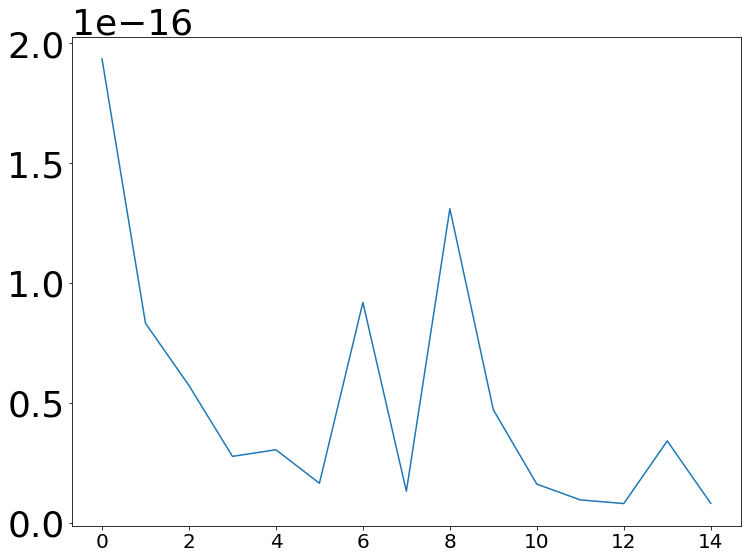

In [276]:
plt.plot(df_list[0]["sideband_amplitude_x"][0]*np.sqrt(5)*9e-13)

# Start with a single distance: 385 um #

In [229]:
distance_x_aerotech = [385]*17
df_list_385 = file_loader_processed(folder_processed,distance_x_aerotech)


/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_2.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_3.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_4.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_5.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_6.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking385/harmonics_basic_with_spin_and_fb_Shaking385_7.pkl
/data/new_trap_processed/harmoni

# Select all with Stroke > 300 and changing z position, while shield constant #

In [231]:
df_sub_list_attr_height = []
attr_height_list = []
for i in [1,4,5,6,7]:
    df_sub_list_attr_height.append(df_list_358[i])
    attr_height_list.append(np.mean(df_list_38Z5[i]["attractor_position_z"]))
    print(np.mean(df_list_385[i]["frequency"]))
    

[ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 143. 156. 169. 182.
 195.]
[ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 143. 156. 169. 182.
 195.]
[ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 143. 156. 169. 182.
 195.]
[ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 143. 156. 169. 182.
 195.]
[ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 143. 156. 169. 182.
 195.]


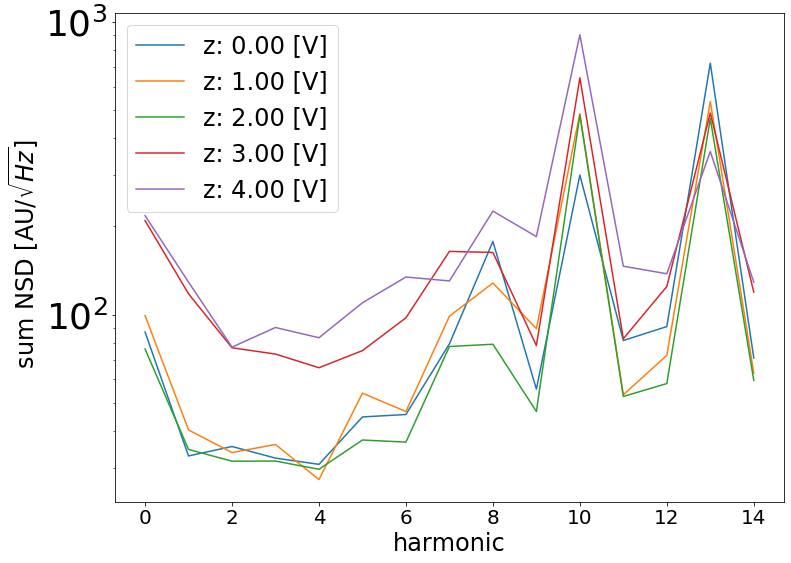

In [234]:
sum_list =[]
df_sub_list = df_sub_list_attr_height
for i in range(len(df_sub_list_attr_height)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="z",no_harmonics=15,norm_factor=1)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="z: %2.2f [V]" %i)#np.mean(df_sub_list[i]["attractor_position_z"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
   # plt.ylim(2e3,1e5)
    plt.legend()
plt.savefig("Results/Dalen_20200106/zforce_z_dependence_constant_shield_385.png", dpi=300, bbox_inches="tight")    
plt.show()    

In [235]:
sum_list_t = np.transpose(sum_list)

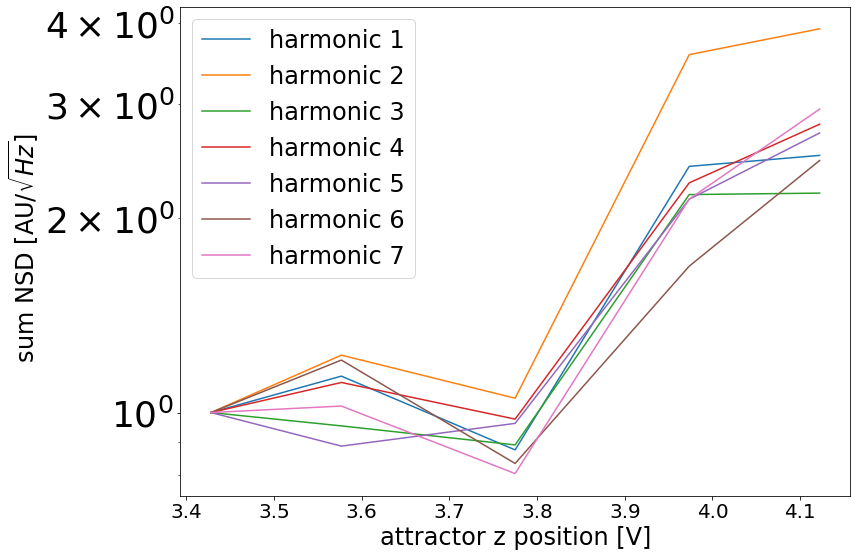

In [236]:
for j in np.arange(0,7,1):    
    plt.plot(attr_height_list,sum_list_t[j]/sum_list_t[j][0], label = "harmonic %d" %(j+1))
    plt.yscale("log")
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("attractor z position [V]")
    plt.legend()
plt.show()    

In [237]:
shield_v_z = [27.5,25,22.5,20.5,18,15.5]

In [238]:
df_sub_list_shield_height = []
#attr_height_list = []
for i in [4,12,13,14,15]:
    df_sub_list_shield_height.append(df_list_385[i])
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))

    

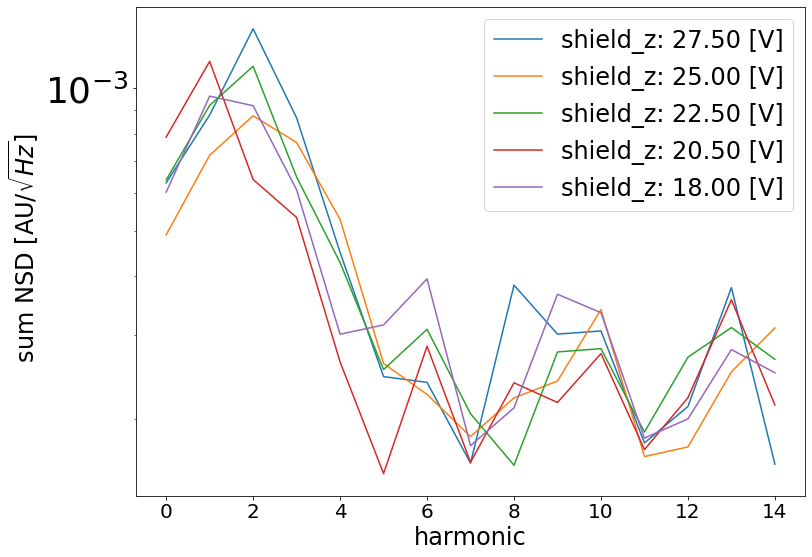

In [240]:
sum_list =[]
df_sub_list = df_sub_list_shield_height
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="shield_z: %2.2f [V]" %np.mean(shield_v_z[i]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend()
plt.savefig("Results/Dalen_20200106/xforce_shield_z_dependence_constant_z_385.png", dpi=300, bbox_inches="tight")        
plt.show()    

In [241]:
df_sub_list_7hz = []
#attr_height_list = []
for i in [8,9]:
    df_sub_list_7hz.append(df_list_385[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))

    

0
1


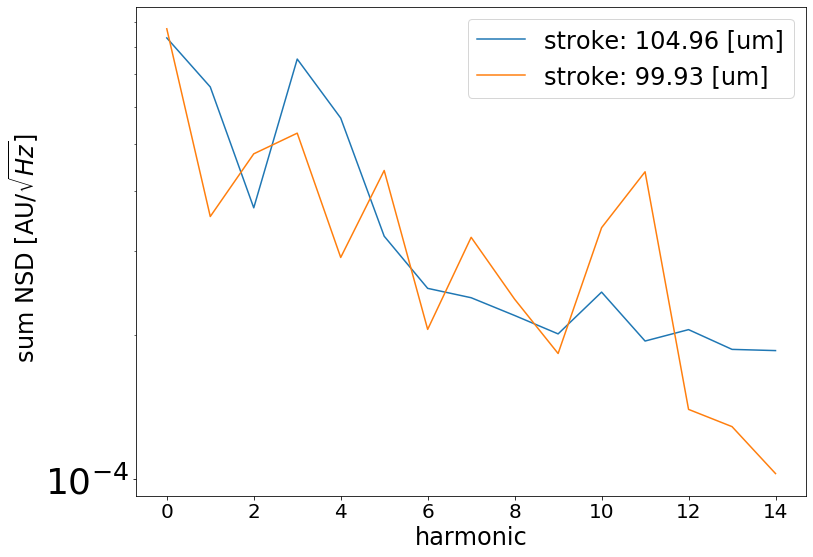

In [242]:
sum_list =[]
df_sub_list = df_sub_list_7hz
for i in range(len(df_sub_list)):
    print(i)
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="stroke: %2.2f [um]" %np.mean(df_sub_list[i]["stroke"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend()
plt.savefig("Results/Dalen_20200106/xforce_servo_vs_no_servo_385.png", dpi=300, bbox_inches="tight")            
plt.show()    

In [243]:
df_sub_list_stroke = []
#attr_height_list = []
for i in [0,1,2]:
    df_sub_list_stroke.append(df_list_385[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))

    

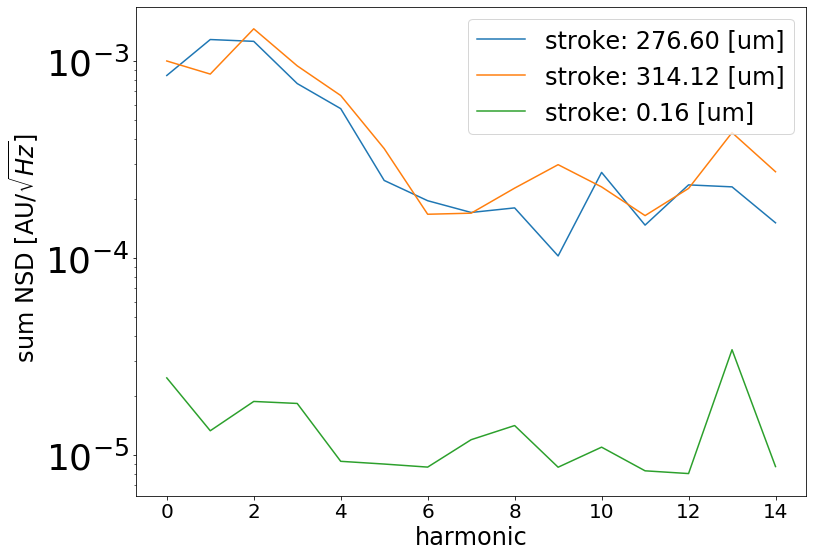

In [244]:
sum_list =[]
df_sub_list = df_sub_list_stroke
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="stroke: %2.2f [um]" %np.mean(df_sub_list[i]["stroke"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
   # plt.ylim(2e3,4e5)
    plt.legend()
plt.savefig("Results/Dalen_20200106/xforce_stroke_z345_385.png", dpi=300, bbox_inches="tight")            
plt.show()    

In [245]:
df_sub_list_stroke_365 = []
#attr_height_list = []
for i in [3,4]:
    df_sub_list_stroke_365.append(df_list_385[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))

    

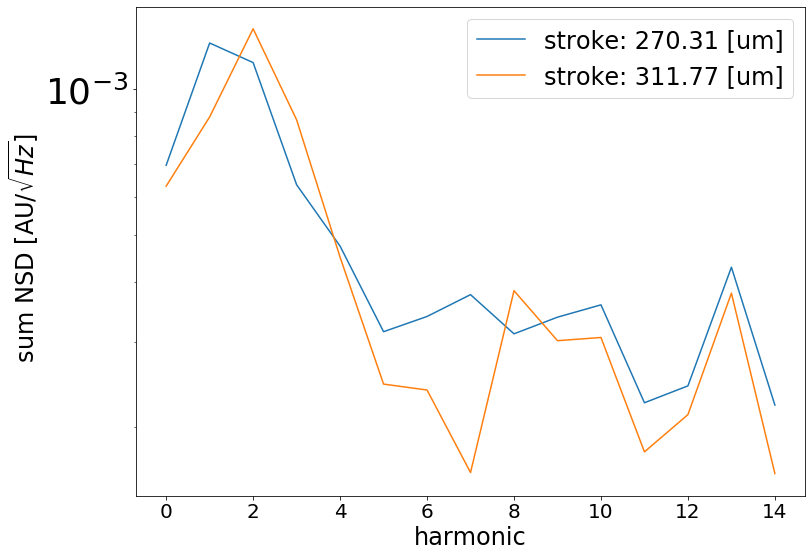

In [246]:
sum_list =[]
df_sub_list = df_sub_list_stroke_365
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15,norm_factor=1)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="stroke: %2.2f [um]" %np.mean(df_sub_list[i]["stroke"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend()
plt.savefig("Results/Dalen_20200106/xforce_stroke_z365_385.png", dpi=300, bbox_inches="tight")            
plt.show()    

# Next distance: 380 um #


In [248]:
distance_x_aerotech = [380]*6
df_list_380 = file_loader_processed(folder_processed,distance_x_aerotech)


/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking380/harmonics_basic_with_spin_and_fb_Shaking380_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking380/harmonics_basic_with_spin_and_fb_Shaking380_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking380/harmonics_basic_with_spin_and_fb_Shaking380_2.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking380/harmonics_basic_with_spin_and_fb_Shaking380_3.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking380/harmonics_basic_with_spin_and_fb_Shaking380_4.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking380/harmonics_basic_with_spin_and_fb_Shaking380_5.pkl


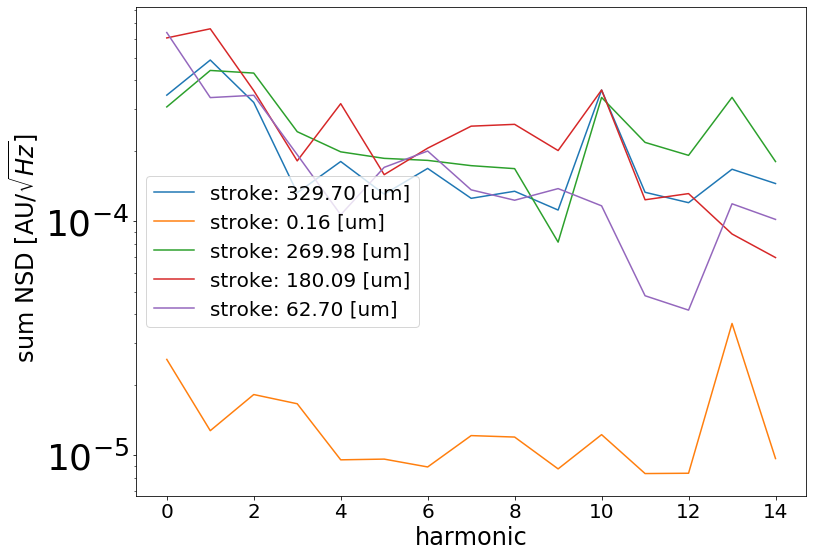

In [249]:
sum_list =[]
df_sub_list = df_list_380[:-1]
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="stroke: %2.2f [um]" %np.mean(df_sub_list[i]["stroke"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=20)
plt.savefig("Results/Dalen_20200106/xforce_stroke_dependency_380.png", dpi=300, bbox_inches="tight")
plt.show()    


# And now 388 um #


In [42]:
distance_x_aerotech = [388]*13
df_list_388 = file_loader_processed(folder_processed,distance_x_aerotech)


/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_2.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_3.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_4.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_5.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_6.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking388/harmonics_basic_with_spin_and_fb_Shaking388_7.pkl
/data/new_trap_processed/harmoni

In [43]:
df_sub_list_7hz_long = []
#attr_height_list = []
for i in [3,4]:
    df_sub_list_7hz_long.append(df_list_388[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))

    

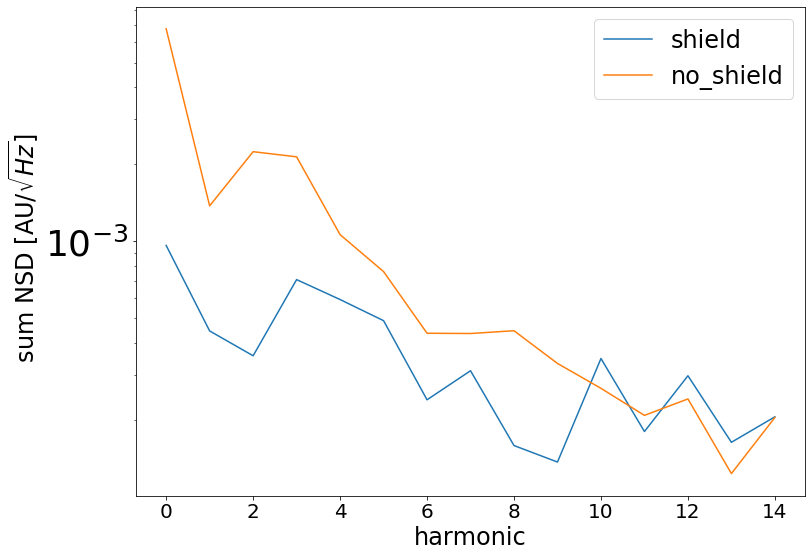

In [61]:
sum_list =[]
df_sub_list = df_sub_list_7hz_long
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)    
plt.plot(np.divide(sum_list[0],len(df_sub_list[0])),linestyle="-",marker="", label="shield")
plt.plot(np.divide(sum_list[1],len(df_sub_list[1])),linestyle="-",marker="", label="no_shield")

plt.yscale("log")
# plt.axhline(10)
plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
plt.xlabel("harmonic")
#plt.ylim(2e3,4e5)
plt.legend()
plt.savefig("Results/Dalen_20200106/xforce_7hz_wservo_shield_no_shield_388.png", dpi=300, bbox_inches="tight")
plt.show()    

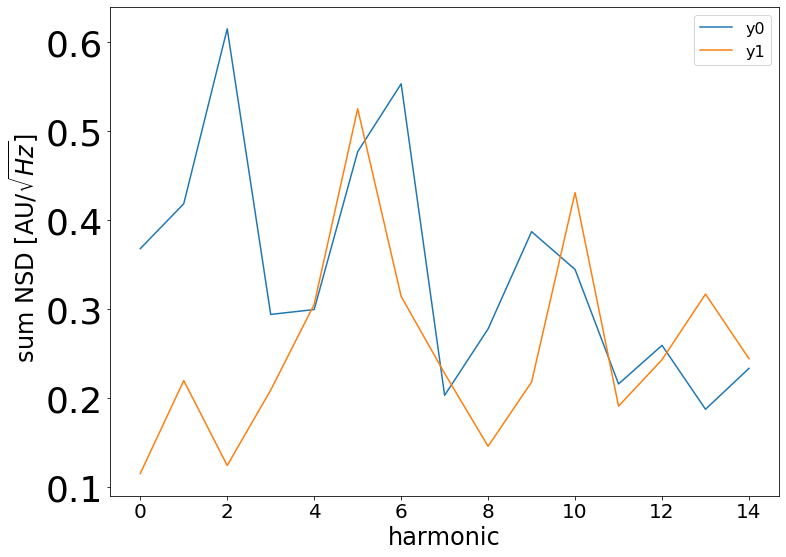

In [143]:
ratio_list_s =[]
df_sub_list = df_sub_list_7hz_long
for i in [0,1]:
    meanwos,sumwos, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="y",no_harmonics=15,norm_factor=norm_y)
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15,norm_factor=norm_x)  
    mean3ws,sum3ws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="z",no_harmonics=15,norm_factor=norm_z)

    ratio_list_s.append(np.divide(sumwos,sumws))
#    plt.plot(np.divide(sumwos,len(df_sub_list[i])),linestyle="-",marker="", label="y")#"%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
#    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="x")#"%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
#    plt.plot(np.divide(sum3ws,len(df_sub_list[i])),linestyle="-",marker="", label="z")#%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
    plt.plot(np.divide(sumwos,sumws),label="y%d" %i) 
    #plt.plot(np.divide(sum3ws,sumws),label="z%d" %i)

    #plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
plt.show()    

In [253]:
df_sub_list_13hz_388 = []
#attr_height_list = []
for i in [0,1,2]:
    df_sub_list_13hz_388.append(df_list_388[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))

    

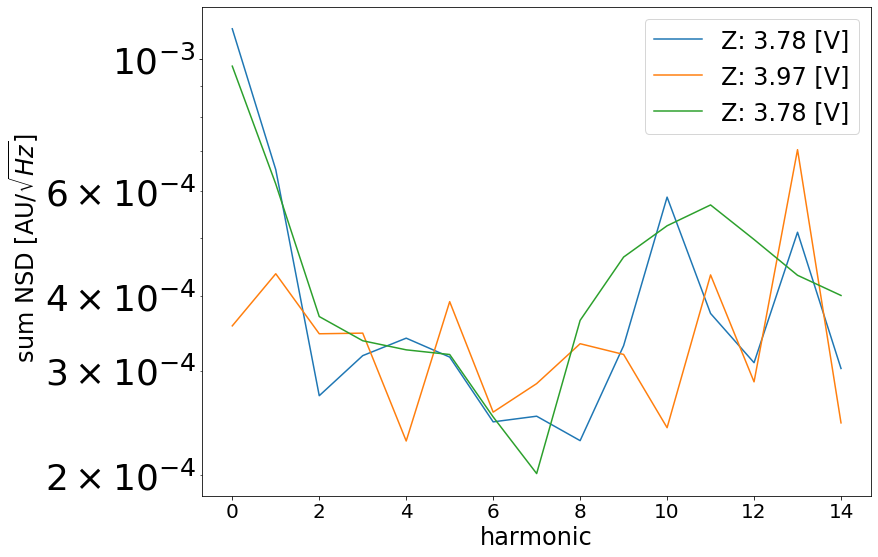

In [254]:
sum_list =[]
df_sub_list = df_sub_list_13hz_388
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="Z: %2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_z"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend()
plt.savefig("Results/Dalen_20200106/x_force_13hz_different_heights_with_shield_388.png", dpi=300, bbox_inches="tight")
plt.show()    

In [255]:
df_sub_list_13hz_higher_shield_388 = []
#attr_height_list = []
for i in [5,10,11,12]:
    df_sub_list_13hz_higher_shield_388.append(df_list_388[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))

    

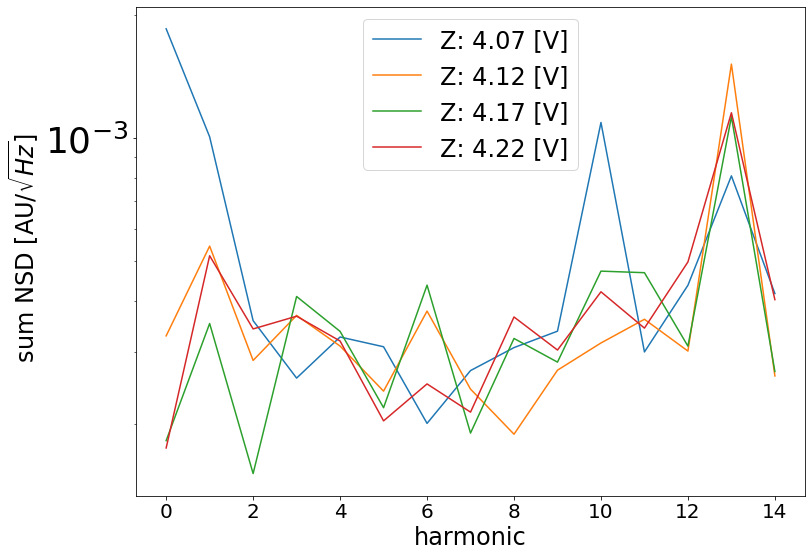

In [256]:
sum_list =[]
df_sub_list = df_sub_list_13hz_higher_shield_388
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="Z: %2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_z"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend()
plt.savefig("Results/Dalen_20200106/x_force_13hz_different_heights_with_raised_shield_388.png", dpi=300, bbox_inches="tight")    
plt.show()    

In [257]:
df_sub_list_freqs_388 = []
#attr_height_list = []
for i in [6,7,8,9,11]:
    df_sub_list_freqs_388.append(df_list_388[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))
freq_list = [7,3,7,3,13]
    

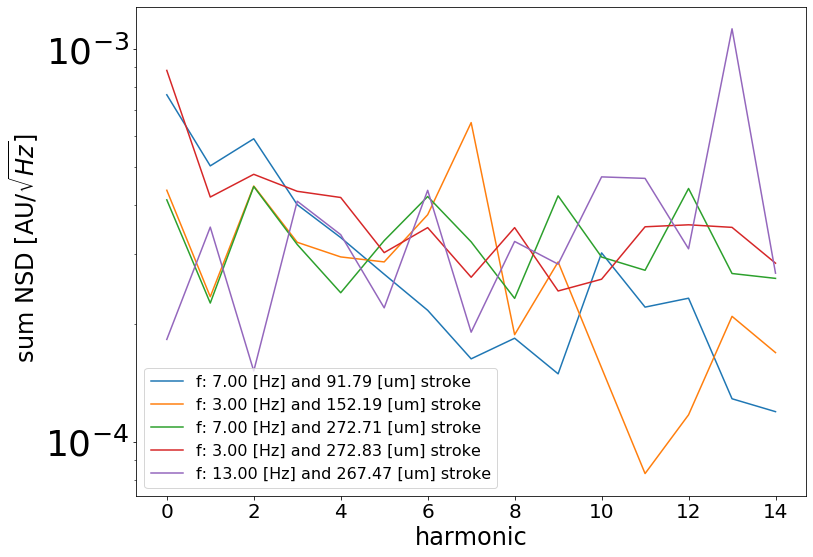

In [258]:
sum_list =[]
df_sub_list = df_sub_list_freqs_388
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="f: %2.2f [Hz] and %2.2f [um] stroke" %(np.mean(freq_list[i]),np.mean(df_sub_list[i]["stroke"])))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
plt.savefig("Results/Dalen_20200106/xforce_different_freqs_with_different_strokes_388.png", dpi=300, bbox_inches="tight")    
plt.show()    

In [259]:
# 390 and 393 #


In [130]:
distance_x_aerotech = [390,390,390,393]
df_list_390 = file_loader_processed(folder_processed,distance_x_aerotech)


/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking390/harmonics_basic_with_spin_and_fb_Shaking390_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking390/harmonics_basic_with_spin_and_fb_Shaking390_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking390/harmonics_basic_with_spin_and_fb_Shaking390_2.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking393/harmonics_basic_with_spin_and_fb_Shaking393_0.pkl


In [136]:
df_sub_list_390 = []
#attr_height_list = []
for i in [0,2,3]:
    df_sub_list_390.append(df_list_390[i])
    #print(i)
    #attr_height_list.append(np.mean(df_list_385[i]["attractor_position_z"]))
freq_list = [7,3,7,3,13]
    

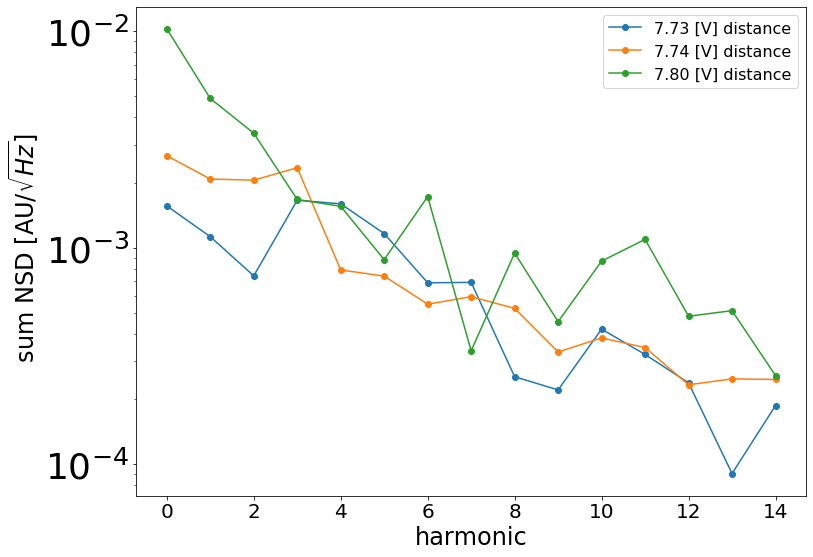

In [140]:
sum_list =[]
df_sub_list = df_sub_list_390
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="o", label="%2.2f [V] distance" %np.mean(df_sub_list[i]["attractor_position_x"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
#plt.savefig("Results/Dalen_20200106/xforce_close_with_and_without_shield.png", dpi=300, bbox_inches="tight")        
plt.show()    

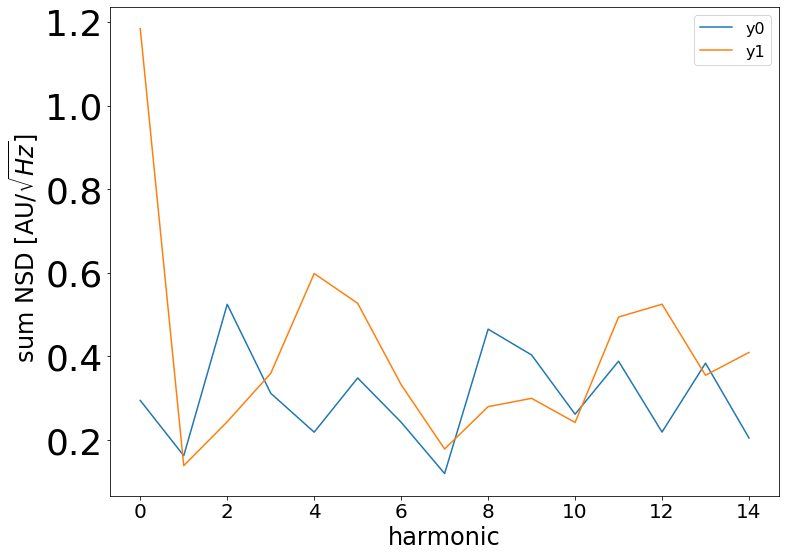

In [142]:
ratio_list_c =[]
df_sub_list = df_sub_list_390
for i in [0,1]:
    meanwos,sumwos, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="y",no_harmonics=15,norm_factor=norm_y)
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15,norm_factor=norm_x)  
    mean3ws,sum3ws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="z",no_harmonics=15,norm_factor=norm_z)

    ratio_list_c.append(np.divide(sumwos,sumws))
#    plt.plot(np.divide(sumwos,len(df_sub_list[i])),linestyle="-",marker="", label="y")#"%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
#    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="x")#"%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
#    plt.plot(np.divide(sum3ws,len(df_sub_list[i])),linestyle="-",marker="", label="z")#%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
    plt.plot(np.divide(sumwos,sumws),label="y%d" %i) 
    #plt.plot(np.divide(sum3ws,sumws),label="z%d" %i)

    #plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
plt.show()    

# add 330 and 68 #

In [263]:
distance_x_aerotech = [68,68,330]
df_list_far = file_loader_processed(folder_processed,distance_x_aerotech)


/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking68/harmonics_basic_with_spin_and_fb_Shaking68_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking68/harmonics_basic_with_spin_and_fb_Shaking68_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking330/harmonics_basic_with_spin_and_fb_Shaking330_0.pkl


In [264]:
df_sub_list=[]

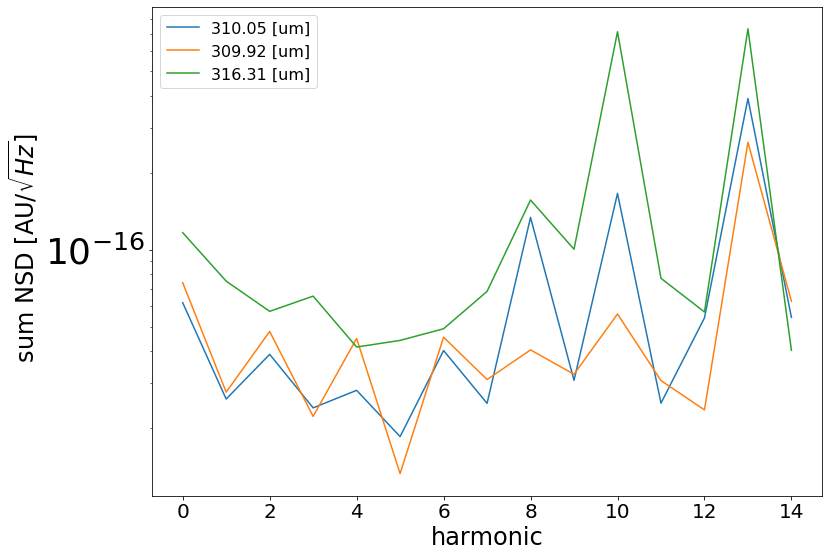

In [265]:
sum_list =[]
df_sub_list = df_list_far
#df_sub_list.append(df_list_388[11])
#df_sub_list.append(df_list_385[2])
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15,norm_factor=1/9e-13)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="%2.2f [um]" %np.mean(df_sub_list[i]["stroke"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
    
plt.show()    

# In n out #

In [17]:
distance_x_aerotech = [355,355,358,358]
df_list_in_n_out = file_loader_processed(folder_processed,distance_x_aerotech)


/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking355/harmonics_basic_with_spin_and_fb_Shaking355_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking355/harmonics_basic_with_spin_and_fb_Shaking355_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking358/harmonics_basic_with_spin_and_fb_Shaking358_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking358/harmonics_basic_with_spin_and_fb_Shaking358_1.pkl


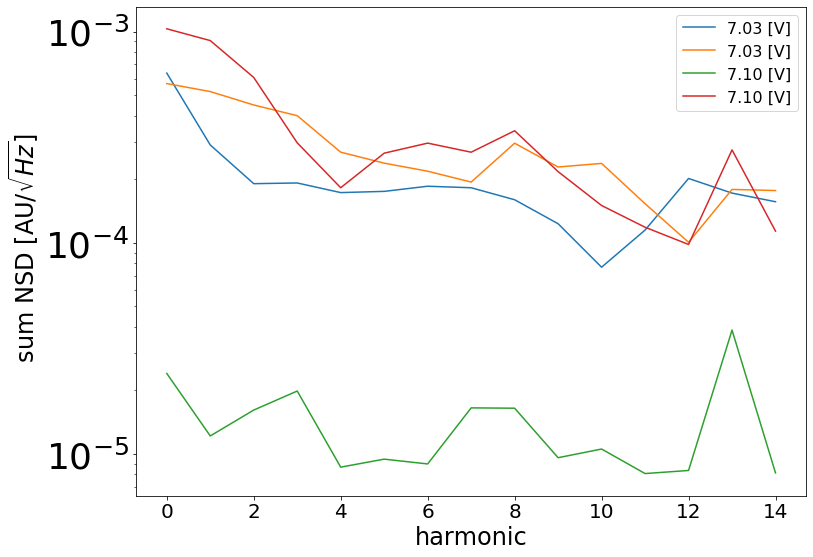

In [37]:
sum_list =[]
df_sub_list = df_list_in_n_out
#df_sub_list.append(df_list_388[11])
#df_sub_list.append(df_list_385[2])
for i in range(len(df_sub_list)):
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15)
    sum_list.append(sumws)
    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
plt.show()    

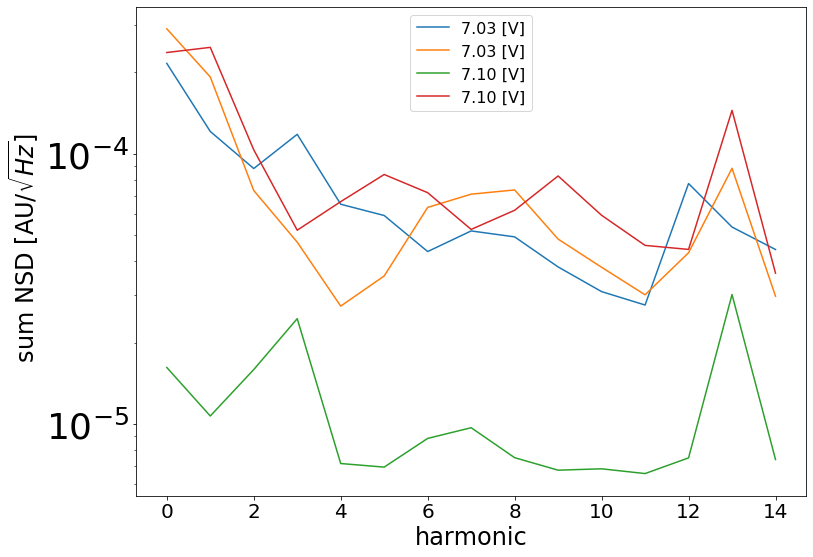

In [38]:
sum_list =[]
df_sub_list = df_list_in_n_out
#df_sub_list.append(df_list_388[11])
#df_sub_list.append(df_list_385[2])
for i in range(len(df_sub_list)):
    meanwos,sumwos, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="y",no_harmonics=15)
    sum_list.append(sumwos)
    plt.plot(np.divide(sumwos,len(df_sub_list[i])),linestyle="-",marker="", label="%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
    plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
plt.show()    

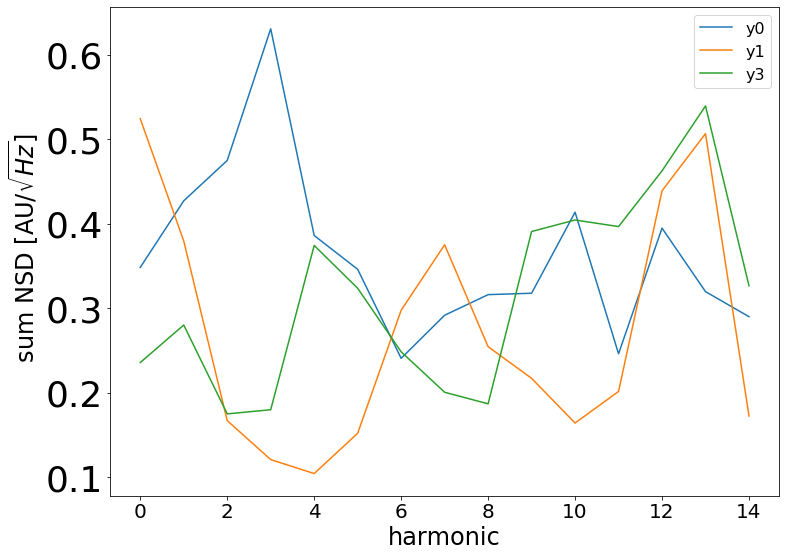

In [88]:
ratio_list_i =[]
df_sub_list = df_list_in_n_out
for i in [0,1,3]:
    meanwos,sumwos, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="y",no_harmonics=15,norm_factor=norm_y)
    meanws,sumws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="x",no_harmonics=15,norm_factor=norm_x)  
    mean3ws,sum3ws, = get_mean_and_sum_of_harmonics(df_sub_list[i],axis="z",no_harmonics=15,norm_factor=norm_z)

    ratio_list_i.append(np.divide(sumwos,sumws))
#    plt.plot(np.divide(sumwos,len(df_sub_list[i])),linestyle="-",marker="", label="y")#"%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
#    plt.plot(np.divide(sumws,len(df_sub_list[i])),linestyle="-",marker="", label="x")#"%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
#    plt.plot(np.divide(sum3ws,len(df_sub_list[i])),linestyle="-",marker="", label="z")#%2.2f [V]" %np.mean(df_sub_list[i]["attractor_position_x"]))
    plt.plot(np.divide(sumwos,sumws),label="y%d" %i)
    #plt.plot(np.divide(sum3ws,sumws),label="z%d" %i)

    #plt.yscale("log")
   # plt.axhline(10)
    plt.ylabel(r" sum NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("harmonic")
    #plt.ylim(2e3,4e5)
    plt.legend(fontsize=16)
plt.show()    

# Time analysis #

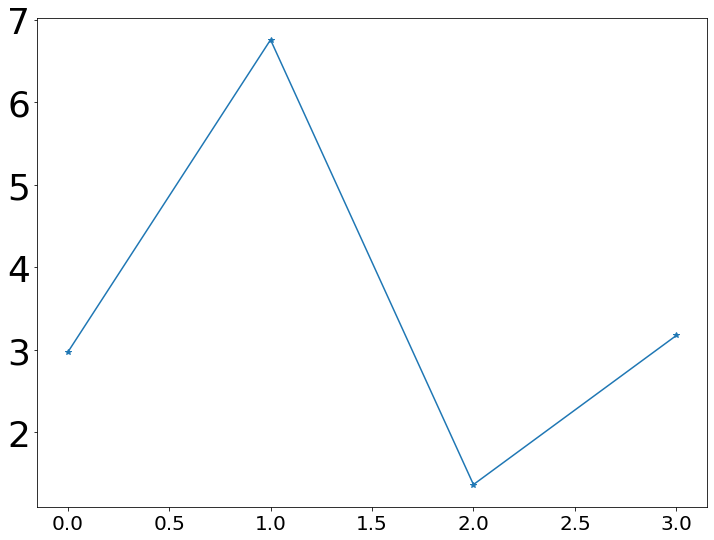

In [36]:
plt.plot(ratio_list,marker="*")

In [48]:
norm_x = 1/9.242334036366173e-13
norm_z = 1/2.78059791556146e-19
norm_y = 1/9.484999875722618e-13

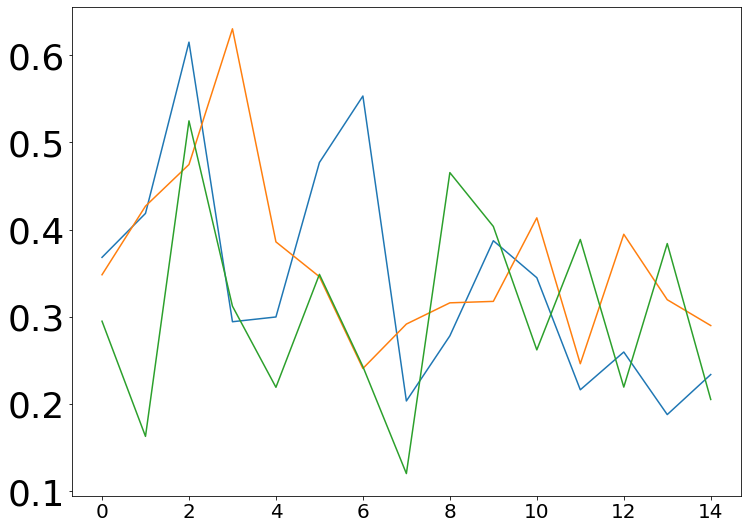

In [148]:
plt.plot(ratio_list_s[0])
plt.plot(ratio_list_i[0])
plt.plot(ratio_list_c[0])


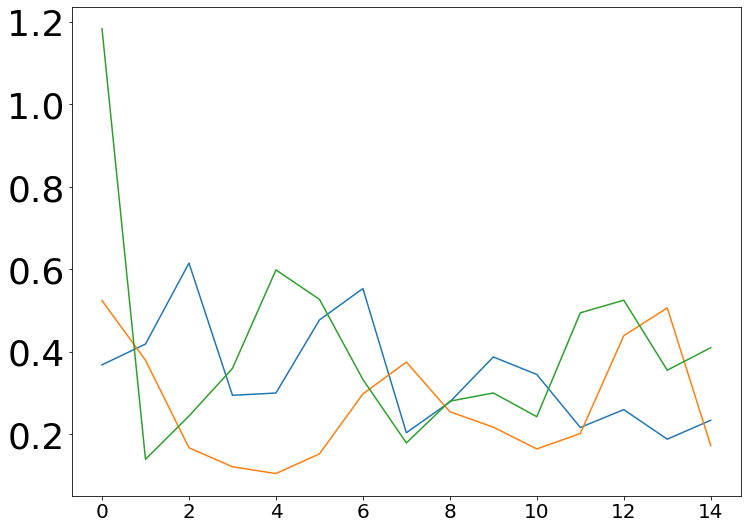

In [149]:
plt.plot(ratio_list_s[0])
plt.plot(ratio_list_i[1])
plt.plot(ratio_list_c[1])
